In [1]:
import pickle
from openmmtools.integrators import LangevinIntegrator
from simtk import openmm
from simtk.openmm import unit 
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from simtk.openmm import XmlSerializer
from openeye import oechem

## Get tyk2 system and minimized state xmls from pickle (there's an env incompatability)

Used perses-nonstandard-aa for this part

In [6]:
# Load tyk2 complex htf
htf_np = np.load('/data/chodera/pulidoi/perses/benchmarks/out_1_7/outhybrid_factory.npy.npz', allow_pickle=True)
htf_dict = htf_np['arr_0'].tolist()

htf = htf_dict['complex']

In [7]:
system = htf.hybrid_system
positions = htf.hybrid_positions
box_vectors = system.getDefaultPeriodicBoxVectors()

In [8]:
# Set up integrator and context
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                                        collision_rate=1 / unit.picoseconds, 
                                                        timestep=4 * unit.femtoseconds)

platform = openmm.Platform.getPlatformByName('CUDA')
context = openmm.Context(system, integrator, platform)
context.setPositions(positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setPositions(positions)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [9]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

In [10]:
with open('tyk2_minimized_state_0.xml', 'w') as f:
    f.write(XmlSerializer.serialize(context.getState(getPositions=True, getVelocities=True)))

with open('tyk2_system.xml', 'w') as f:
    f.write(XmlSerializer.serialize(system))


## Prep for getting energies at lambda = 0


Use perses-rest-over-protocol env for rest of the experiments

In [55]:
with open('tyk2_minimized_state_0.xml') as input:
    state = XmlSerializer.deserialize(input.read())

with open('tyk2_system.xml') as input:
    system = XmlSerializer.deserialize(input.read())
    

In [56]:
# Set up integrator and context
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                collision_rate=1 / unit.picoseconds, 
                                timestep=4 * unit.femtoseconds)

platform = openmm.Platform.getPlatformByName('CUDA')
context = openmm.Context(system, integrator, platform)
# context.setPositions(positions)
# context.setPeriodicBoxVectors(*box_vectors)
# context.setPositions(positions)
# context.setVelocitiesToTemperature(300 * unit.kelvin)
context.setState(state)

In [36]:
system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b6c81f3fa20> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b6c81f3f720> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2b6c81f3fa50> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b6c81f3f660> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b6c81f3fe70> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b6c81f3fae0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b6c81f3fe10> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b6c81f3fd20> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of t

In [37]:
system.getForce(7).getCutoffDistance()

Quantity(value=1.0, unit=nanometer)

In [38]:
system.getForce(8).getCutoffDistance()

Quantity(value=1.0, unit=nanometer)

## Get coefficient at lambda = 0 (Peter's code)

In [57]:
system.getForce(7).setUseDispersionCorrection(False)
system.getForce(8).setUseLongRangeCorrection(False)
system.getForce(7).setForceGroup(1) # so we can query just the nonbonded forces
system.getForce(8).setForceGroup(1)

e1 = context.getState(getEnergy=True, groups={1}).getPotentialEnergy()
system.getForce(7).setUseDispersionCorrection(True)
system.getForce(8).setUseLongRangeCorrection(True)

context.reinitialize(preserveState=True) # otherwise it won't see the change to the force
e2 = context.getState(getEnergy=True, groups={1}).getPotentialEnergy()
volume = context.getState().getPeriodicBoxVolume()
print('coefficient:', (e2-e1)*volume)

coefficient: 1391444606.7349782 nm**3 kJ/mol


## Get energy at lambda = 0 without correction

In [7]:
system.getForce(7).setUseDispersionCorrection(False)

In [8]:
system.getForce(8).setUseLongRangeCorrection(False)

In [9]:
state = context.getState(getEnergy=True, getParameters=True)

In [10]:
state.getPotentialEnergy()

Quantity(value=-812145.9588281967, unit=kilojoule/mole)

In [11]:
state.getPeriodicBoxVolume()

Quantity(value=523.509176644875, unit=nanometer**3)

## Get energy at lambda = 0 with correction

In [12]:
system.getForce(7).setUseDispersionCorrection(True)

In [13]:
system.getForce(8).setUseLongRangeCorrection(True)

In [14]:
state = context.getState(getEnergy=True, getParameters=True)

In [15]:
state.getPotentialEnergy()

Quantity(value=-812145.9588281967, unit=kilojoule/mole)

In [16]:
state.getPeriodicBoxVolume()

Quantity(value=523.509176644875, unit=nanometer**3)

##  Set endstate to lambda = 1

In [51]:
with open('tyk2_minimized_state_1.xml') as input:
    state = XmlSerializer.deserialize(input.read())

with open('tyk2_system.xml') as input:
    system = XmlSerializer.deserialize(input.read())
    

In [52]:
# Set up integrator and context
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                                        collision_rate=1 / unit.picoseconds, 
                                                        timestep=4 * unit.femtoseconds)

platform = openmm.Platform.getPlatformByName('CUDA')
context = openmm.Context(system, integrator, platform)
# context.setPositions(positions)
# context.setPeriodicBoxVectors(*box_vectors)
# context.setPositions(positions)
# context.setVelocitiesToTemperature(300 * unit.kelvin)
context.setState(state)

In [53]:
for k, v in context.getParameters().items():
    if 'lambda' in k:
        context.setParameter(k, 1.0)
        
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_angles 1.0
lambda_bonds 1.0
lambda_electrostatics_core 1.0
lambda_electrostatics_delete 1.0
lambda_electrostatics_insert 1.0
lambda_sterics_core 1.0
lambda_sterics_delete 1.0
lambda_sterics_insert 1.0
lambda_torsions 1.0
softcore_alpha 0.5


In [18]:
# # Minimize
# openmm.LocalEnergyMinimizer.minimize(context)

In [19]:
# with open('tyk2_minimized_state_1.xml', 'w') as f:
#     f.write(XmlSerializer.serialize(context.getState(getPositions=True, getVelocities=True)))


## Get coefficient at lambda = 1 (Peter's code)

In [54]:
system.getForce(7).setUseDispersionCorrection(False)
system.getForce(8).setUseLongRangeCorrection(False)
system.getForce(7).setForceGroup(1) # so we can query just the nonbonded forces
system.getForce(8).setForceGroup(1)

e1 = context.getState(getEnergy=True, groups={1}).getPotentialEnergy()
system.getForce(7).setUseDispersionCorrection(True)
system.getForce(8).setUseLongRangeCorrection(True)

context.reinitialize(preserveState=True) # otherwise it won't see the change to the force
e2 = context.getState(getEnergy=True, groups={1}).getPotentialEnergy()
volume = context.getState().getPeriodicBoxVolume()
print('coefficient:', (e2-e1)*volume)

coefficient: 1391370281.631637 nm**3 kJ/mol


## Get energy at lambda = 1 without correction

In [20]:
system.getForce(7).setUseDispersionCorrection(False)

In [21]:
system.getForce(8).setUseLongRangeCorrection(False)

In [22]:
state = context.getState(getEnergy=True, getParameters=True)

In [23]:
state.getPotentialEnergy()

Quantity(value=-812296.8338281967, unit=kilojoule/mole)

In [24]:
state.getPeriodicBoxVolume()

Quantity(value=523.509176644875, unit=nanometer**3)

## Get energy at lambda = 1 with correction

In [25]:
system.getForce(7).setUseDispersionCorrection(True)

In [26]:
system.getForce(8).setUseLongRangeCorrection(True)

In [27]:
state = context.getState(getEnergy=True, getParameters=True)

In [28]:
state.getPotentialEnergy()

Quantity(value=-812296.8338281967, unit=kilojoule/mole)

In [29]:
state.getPeriodicBoxVolume()

Quantity(value=523.509176644875, unit=nanometer**3)

## Get energies and box volumes for lambda = 0

In [30]:
with open('tyk2_minimized_state_0.xml') as input:
    state = XmlSerializer.deserialize(input.read())

with open('tyk2_system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

In [31]:
# Set up integrator and context
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                                        collision_rate=1 / unit.picoseconds, 
                                                        timestep=4 * unit.femtoseconds)

platform = openmm.Platform.getPlatformByName('CUDA')
context = openmm.Context(system, integrator, platform)
# context.setPositions(positions)
# context.setPeriodicBoxVectors(*box_vectors)
# context.setPositions(positions)
# context.setVelocitiesToTemperature(300 * unit.kelvin)
context.setState(state)

In [32]:
for k, v in context.getParameters().items():
    if 'lambda' in k:
        context.setParameter(k, 0.0)
        
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_angles 0.0
lambda_bonds 0.0
lambda_electrostatics_core 0.0
lambda_electrostatics_delete 0.0
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.0
lambda_sterics_delete 0.0
lambda_sterics_insert 0.0
lambda_torsions 0.0
softcore_alpha 0.5


In [33]:
system.getForce(7).setUseDispersionCorrection(False)
system.getForce(8).setUseLongRangeCorrection(False)

In [34]:
volumes_0 = []
energies_0_without_correction = []
energies_0_with_correction = []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get box volume and energy without correction
    state = context.getState(getEnergy=True)
    volumes_0.append(state.getPeriodicBoxVolume().value_in_unit_system(unit.md_unit_system))
    energies_0_without_correction.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    
    # Get energy with correction
    system.getForce(7).setUseDispersionCorrection(True)
    system.getForce(8).setUseLongRangeCorrection(True)
    state = context.getState(getEnergy=True)
    energies_0_with_correction.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    
    # Turn correction off
    system.getForce(7).setUseDispersionCorrection(False)
    system.getForce(8).setUseLongRangeCorrection(False)

/scratch/lsftmp/4041702.tmpdir/ipykernel_18426/512206467.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
with open("tyk2_volumes_0.npy", "wb") as f:
    np.save(f, np.array(volumes_0))
    
with open("tyk2_energies_0_without_correction.npy", "wb") as f:
    np.save(f, np.array(energies_0_without_correction))
    
with open("tyk2_energies_0_with_correction.npy", "wb") as f:
    np.save(f, np.array(energies_0_with_correction))

In [14]:
with open("tyk2_volumes_0.npy", "rb") as f:
    volumes_0 = np.load(f)
    

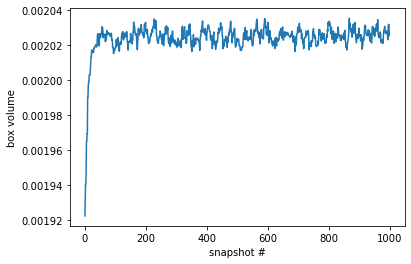

In [15]:
plt.plot(1/np.array(volumes_0))
plt.ylabel('box volume')
plt.xlabel('snapshot #')
plt.show()

In [16]:
np.mean(1/np.array(volumes_0[300:]))

0.0020253639646206404

In [17]:
np.std(1/np.array(volumes_0[300:]))

3.7006908511059544e-06

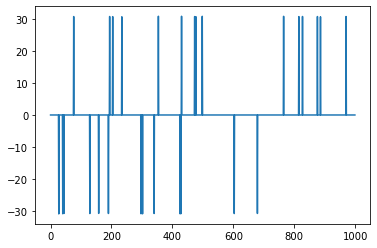

In [39]:
plt.plot((np.array(energies_0_with_correction) - np.array(energies_0_without_correction))*np.array(volumes_0))

In [40]:
np.mean((np.array(energies_0_with_correction) - np.array(energies_0_without_correction))*np.array(volumes_0))

0.0609348559135845

In [41]:
np.std((np.array(energies_0_with_correction) - np.array(energies_0_without_correction))*np.array(volumes_0))

5.1640113240166015

## Get box volumes for lambda = 1 (without correction)

In [2]:
with open('tyk2_minimized_state_1.xml') as input:
    state = XmlSerializer.deserialize(input.read())

with open('tyk2_system.xml') as input:
    system = XmlSerializer.deserialize(input.read())

In [3]:
# Set up integrator and context
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                                        collision_rate=1 / unit.picoseconds, 
                                                        timestep=4 * unit.femtoseconds)

platform = openmm.Platform.getPlatformByName('CUDA')
context = openmm.Context(system, integrator, platform)
# context.setPositions(positions)
# context.setPeriodicBoxVectors(*box_vectors)
# context.setPositions(positions)
# context.setVelocitiesToTemperature(300 * unit.kelvin)
context.setState(state)

In [4]:
for k, v in context.getParameters().items():
    if 'lambda' in k:
        context.setParameter(k, 1.0)
        
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_angles 1.0
lambda_bonds 1.0
lambda_electrostatics_core 1.0
lambda_electrostatics_delete 1.0
lambda_electrostatics_insert 1.0
lambda_sterics_core 1.0
lambda_sterics_delete 1.0
lambda_sterics_insert 1.0
lambda_torsions 1.0
softcore_alpha 0.5


In [5]:
system.getForce(8).setUseLongRangeCorrection(False)
system.getForce(7).setUseDispersionCorrection(False)

In [6]:
volumes_1 = []
energies_1_without_correction = []
energies_1_with_correction = []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get box volume and energy without correction
    state = context.getState(getEnergy=True)
    volumes_1.append(state.getPeriodicBoxVolume().value_in_unit_system(unit.md_unit_system))
    energies_1_without_correction.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    
    # Get energy with correction
    system.getForce(7).setUseDispersionCorrection(True)
    system.getForce(8).setUseLongRangeCorrection(True)
    state = context.getState(getEnergy=True)
    energies_1_with_correction.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    
    # Turn correction off
    system.getForce(7).setUseDispersionCorrection(False)
    system.getForce(8).setUseLongRangeCorrection(False)

/scratch/lsftmp/4042699.tmpdir/ipykernel_1309/1607465935.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
with open("tyk2_volumes_1.npy", "wb") as f:
    np.save(f, np.array(volumes_1))
    
with open("tyk2_energies_1_without_correction.npy", "wb") as f:
    np.save(f, np.array(energies_1_without_correction))
    
with open("tyk2_energies_1_with_correction.npy", "wb") as f:
    np.save(f, np.array(energies_1_with_correction))

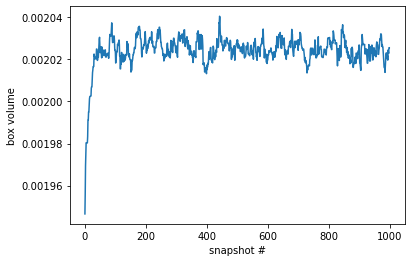

In [8]:
plt.plot(1/np.array(volumes_1))
plt.ylabel('box volume')
plt.xlabel('snapshot #')
plt.show()

In [11]:
np.mean(1/np.array(volumes_1[300:]))

0.002024878962158837

In [12]:
np.std(1/np.array(volumes_1[300:]))

4.267036202637575e-06

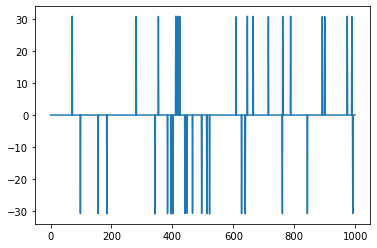

In [51]:
plt.plot((np.array(energies_1_with_correction) - np.array(energies_1_without_correction))*np.array(volumes_1))

In [52]:
np.mean((np.array(energies_1_with_correction) - np.array(energies_1_without_correction))*np.array(volumes_1))

-0.06163438665437092

In [53]:
np.std((np.array(energies_1_with_correction) - np.array(energies_1_without_correction))*np.array(volumes_1))

5.688603035895988